# PRNU Anonymization through Deep Image Prior
@Author: Francesco Picetti - francesco.picetti@polimi.it

In [ ]:
from __future__ import print_function
import warnings
warnings.filterwarnings("ignore")

import os
import torch
import numpy as np
import matplotlib.image as mpimg
from scipy.io import loadmat

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True
dtype = torch.cuda.FloatTensor
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
from architectures import UNet, Skip, DnCNN
from utils.common_utils import *
from utils import utils as u

from argparse import Namespace
from collections import namedtuple
from time import time
from termcolor import colored
from glob import glob
import json

# this is defined here because of pickle
History = namedtuple("History", ['loss', 'psnr', 'ssim', 'ncc_w', 'ncc_d'])


In [ ]:
class Training:
    def __init__(self, args, dtype, outpath, img_shape=(512, 512, 3)):
        self.args = args
        self.dtype = dtype
        self.outpath = outpath
        self.img_shape = img_shape
        self.l2dist = torch.nn.MSELoss().type(self.dtype)
        self.history = History([], [], [], [], [])
        self.elapsed = None
        self.iiter = 0
        self.saving_interval = 0
        self.psnr_max = 0

        self.imgpath = None
        self.image_name = None
        self.img = None
        self.img_tensor = None
        self.prnu = None
        self.prnu_tensor = None
        self.out_img = None

        # build input tensors
        self.input_tensor = None
        self.input_tensor_old = None
        self.additional_noise_tensor = None
        self.build_input()

        # build network
        self.net = None
        self.parameters = None
        self.num_params = None
        self.build_model()
        self.dncnn = DnCNN().to(self.input_tensor.device)

    def build_input(self):
        self.input_tensor = get_noise(self.args.input_depth, 'noise', self.img_shape[:2],
                                      noise_type=self.args.noise_dist, var=self.args.noise_std).type(dtype)
        self.input_tensor_old = self.input_tensor.detach().clone()
        self.additional_noise_tensor = self.input_tensor.detach().clone()

    def build_model(self):
        if self.args.network == 'unet':
            self.net = UNet(num_input_channels=self.args.input_depth,
                            num_output_channels=self.img_shape[-1],
                            filters=self.args.filters,
                            more_layers=1,  # default is 0
                            concat_x=False,
                            upsample_mode=self.args.upsample,  # default is nearest
                            activation=self.args.activation,
                            pad=self.args.pad,  # default is zero
                            norm_layer=torch.nn.InstanceNorm2d,
                            need_sigmoid=self.args.need_sigmoid,
                            need_bias=True
                            ).type(self.dtype)
        elif self.args.network == 'skip':
            self.net = Skip(num_input_channels=self.args.input_depth,
                            num_output_channels=self.img_shape[-1],
                            num_channels_down=self.args.filters,
                            num_channels_up=self.args.filters,
                            num_channels_skip=self.args.skip,
                            upsample_mode=self.args.upsample,  # default is bilinear
                            need_sigmoid=self.args.need_sigmoid,
                            need_bias=True,
                            pad=self.args.pad,  # default is reflection, but Fantong uses zero
                            act_fun=self.args.activation  # default is LeakyReLU
                            ).type(self.dtype)
        else:
            raise ValueError('ERROR! The network has to be either unet or skip')
        self.parameters = get_params('net', self.net, self.input_tensor)
        self.num_params = sum(np.prod(list(p.size())) for p in self.net.parameters())

    def load_image(self, image_path):
        self.imgpath = image_path
        self.image_name = self.imgpath.split('.')[-2].split('/')[-1]
        self.img = mpimg.imread(image_path)
        if self.img.shape != self.img_shape:
            raise ValueError('The loaded image shape has to be', self.img_shape)
        self.img_tensor = u.numpy2torch(np.swapaxes(self.img, 2, 0)[np.newaxis])

    def load_prnu(self, device_path):
        self.prnu = loadmat(os.path.join(device_path, 'prnu_cropped512.mat'))['prnu']
        if self.prnu.shape != self.img_shape[:2]:
            raise ValueError('The loaded PRNU shape has to be', self.img_shape[:2])
        self.prnu_tensor = u.numpy2torch(self.prnu[np.newaxis, np.newaxis])

    def optimization_loop(self):
        if self.args.param_noise:
            for n in [x for x in self.net.parameters() if len(x.size()) == 4]:
                n += n.detach().clone().normal_() * n.std() / 50

        input_tensor = self.input_tensor_old
        if self.args.reg_noise_std > 0:
            input_tensor = self.input_tensor_old + (self.additional_noise_tensor.normal_() * self.args.reg_noise_std)

        output_tensor = self.net(input_tensor)
        w = self.dncnn(u.rgb2gray(output_tensor, 1))

        if self.args.gamma == 0.:  # MSE between reference image and output image
            total_loss = self.l2dist(output_tensor, self.img_tensor)
        else:  # MSE between reference image and output image with true PRNU (weighted by gamma)
            total_loss = self.l2dist(u.add_prnu(output_tensor, self.prnu_tensor, weight=self.args.gamma),
                                     self.img_tensor)

        if self.args.beta != 0.:  # cross-correlation between the true PRNU and the one extracted by the DnCNN
            # w = self.dncnn(u.rgb2gray(output_tensor, 1))
            total_loss += self.args.beta * u.ncc(self.prnu_tensor * u.rgb2gray(output_tensor, 1), w)

        total_loss.backward()

        self.history.loss.append(total_loss.item())
        self.history.psnr.append(u.psnr(output_tensor * 255, self.img_tensor * 255, 1).item())
        self.history.ssim.append(u.ssim(self.img_tensor, output_tensor).item())
        msg = "Processing %s,\tIter %s, Loss = %.2e, PSNR = %.2f dB, SSIM = %.4f" \
              % (self.imgpath.split('/')[-1], str(self.iiter+1).zfill(u.ten_digit(self.args.epochs)),
                 self.history.loss[-1], self.history.psnr[-1], self.history.ssim[-1])

        out_img = np.swapaxes(u.torch2numpy(output_tensor).squeeze(), 0, -1)
        self.history.ncc_w.append(u.ncc(self.prnu * u.float2png(u.prnu.rgb2gray(out_img)),
                                        u.prnu.extract_single(u.float2png(out_img))))
        msg += ', NCC_w = %.6f' % self.history.ncc_w[-1]

        if self.args.nccd:  # compute also the final NCC with DnCNN
            self.history.ncc_d.append(u.ncc(self.prnu_tensor * u.rgb2gray(output_tensor, 1), w).item())
            msg += ', NCC_d = %.6f' % self.history.ncc_d[-1]

        print(colored(msg, 'yellow'), '\r', end='')

        # # save every N iterations
        # if self.args.save_every != 0 and self.iiter % self.args.save_every == 0:
        #     outname = self.image_name + \
        #               '_i' + str(self.iiter).zfill(u.ten_digit(self.args.epochs)) + \
        #               '_psnr%.2f.png' % self.history.psnr[-1]
        #     Image.fromarray(u.float2png(self.out_img)).save(os.path.join(self.outpath, outname))

        # save if the PSNR is increasing (above a threshold) and only every tot iterations
        if self.psnr_max < self.history.psnr[-1]:
            self.psnr_max = self.history.psnr[-1]
            self.out_img = out_img
            if self.psnr_max > self.args.psnr_min and \
                    self.iiter > 0 and self.saving_interval >= self.args.save_every:
                outname = self.image_name + \
                          '_i' + str(self.iiter).zfill(u.ten_digit(self.args.epochs)) + \
                          '_psnr%.2f_nccw%.6f.png' % (self.history.psnr[-1], self.history.ncc_d[-1])
                Image.fromarray(u.float2png(self.out_img)).save(os.path.join(self.outpath, outname))
                self.saving_interval = 0

        self.iiter += 1
        self.saving_interval += 1

        return total_loss

    def optimize(self):
        start = time()
        optimize(self.args.optimizer, self.parameters, self.optimization_loop, self.args.lr, self.args.epochs)
        self.elapsed = time() - start

    def save_result(self):
        mydict = {
            'server': u.machine_name(),
            'device': os.environ["CUDA_VISIBLE_DEVICES"],
            'elapsed time': u.sec2time(self.elapsed),
            'run_code': self.outpath[-6:],
            'history': self.history,
            'args': self.args,
            'prnu': self.prnu,
            'image': self.img,
            'anonymized': self.out_img,
            'psnr_max': self.psnr_max,
            'params': self.num_params
        }
        np.save(os.path.join(self.outpath,
                             self.image_name.split('/')[-1] + '_run.npy'), mydict)

    def clean(self):
        self.iiter = 0
        self.saving_interval = 0
        print('')
        torch.cuda.empty_cache()
        self.build_input()
        self.build_model()
        self.history = History([], [], [], [], [])


### Parameters

In [2]:
args = Namespace(
    datapath=,
    gpu=-1,
    pic_per_dev=-1,
    network='skip',
    activation='ReLU',
    need_sigmoid=True,
    filters=[128,128,128,128],
    skip=[0,0,4,4],
    input_depth=512,
    pad='zero',
    upsample='nearest',
    optimizer='adam',
    nccd=True,
    gamma=0.01,
    beta=0.0,
    epochs=6001,
    lr=1e-3,
    save_every=0,
    psnr_min=30.,
    param_noise=False,
    reg_noise_std=0.03,
    noise_dist='uniform',
    noise_std=.1
)

datapath = './dataset/Nikon_D70s_1/'
input_image = 'Nikon_D70s_1_22903.png'

In [3]:
random_code = u.random_code()

# set the engine to be used
u.set_gpu(gpu)

GPU selected: 0 - GeForce GTX 1080 Ti


In [4]:
# create output folder: ./camera_model/picture_name/random_code/
outpath = os.path.join(datapath, input_image.split('.')[0], random_code)
if not os.path.exists(outpath):
    os.makedirs(outpath)

In [5]:
# load data
img = mpimg.imread(os.path.join(datapath, input_image))
prnu = loadmat(os.path.join(datapath, 'prnu_cropped512.mat'))['prnu']

In [6]:
# image to tensor
img_tensor = u.numpy2torch(np.swapaxes(img, 2, 0)[np.newaxis])
prnu_tensor = u.numpy2torch(prnu[np.newaxis, np.newaxis])

In [7]:
im_gray = u.rgb2gray(img_tensor)

ValueError: Input image must have 1 or 3 channels

In [8]:
img_tensor.shape

torch.Size([1, 3, 512, 512])

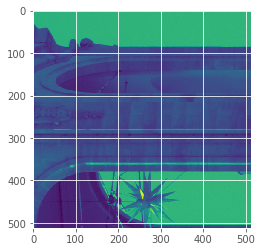

In [36]:
plt.imshow(u.torch2numpy(im_gray))

In [24]:
# create input noise tensor
input_tensor = get_noise(input_depth, 'noise', img.shape,
                         noise_type=noise_dist, var=noise_std).type(dtype)
input_tensor_old = input_tensor.detach().clone()
additional_noise_tensor = input_tensor.detach().clone()

In [8]:
# create network
if network == 'unet':
    net = UNet(num_input_channels=input_depth,
               num_output_channels=img.shape[-1],
               filters=filters,
               more_layers=1,  # default is 0
               concat_x=False,
               upsample_mode=upsample,  # default is nearest
               activation=activation,
               pad=pad,  # default is zero
               norm_layer=torch.nn.InstanceNorm2d,
               need_sigmoid=need_sigmoid,
               need_bias=True
               ).type(dtype)
elif network == 'skip':
    net = Skip(num_input_channels=input_depth,
               num_output_channels=img.shape[-1],
               num_channels_down=filters,
               num_channels_up=filters,
               num_channels_skip=skip,
               upsample_mode=upsample,  # default is bilinear
               need_sigmoid=need_sigmoid,
               need_bias=True,
               pad=pad,  # default is reflection, but Fantong uses zero
               act_fun=activation  # default is LeakyReLU
               ).type(dtype)
else:
    raise ValueError('ERROR! The network has to be either unet or skip')

In [10]:
# Define function to be minimized
l2dist = torch.nn.MSELoss().type(dtype)
iiter = 0
# history = {'loss':[], 'psnr':[], 'ssim':[], 'ncc':[]}
History = namedtuple("History", ['loss', 'psnr', 'ssim', 'ncc'])
history = History([],[],[],[])

def closure_function():

    global iiter
    global out_numpy
    global history

    if param_noise:
        for n in [x for x in net.parameters() if len(x.size()) == 4]:
            n = n + n.detach().clone().normal_() * n.std() / 50

    input_tensor = input_tensor_old
    if reg_noise_std > 0:
        input_tensor = input_tensor_old + (additional_noise_tensor.normal_() * reg_noise_std)

    output_tensor = net(input_tensor)
    if alpha == 0.:
        total_loss = l2dist(output_tensor, img_tensor)
    else:
        total_loss = l2dist(u.add_prnu(output_tensor, prnu_tensor, weight=alpha), img_tensor)
    total_loss.backward()

    out_numpy = np.swapaxes(u.torch2numpy(output_tensor).squeeze(), 0, -1)

    history.loss.append(total_loss.item())
    history.psnr.append(u.psnr(u.float2png(out_numpy), u.float2png(img)))
    history.ssim.append(u.ssim(img, out_numpy))
    history.ncc.append(u.ncc(prnu, u.prnu.rgb2gray(out_numpy) * u.prnu.extract_single(u.float2png(out_numpy))))

    print('Iteration %5d, Loss = %.2e, PSNR = %.2f dB, SSIM = %.4f, NCC = %.6f'
          % (iiter, history.loss[-1], history.psnr[-1], history.ssim[-1], history.ncc[-1]),
          '\r', end='')

    if save_every != 0 and iiter % save_every == 0:
        plt.figure(figsize=(12,6))
        plt.subplot(121), plt.imshow(img), plt.title('Original')
        plt.subplot(122), plt.imshow(out_numpy), plt.title('Anonymized')
        plt.show()
    iiter += 1

    return total_loss

Starting optimization with ADAM


/nas/home/fpicetti/miniconda3/envs/deep-image-prior/lib/python3.7/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


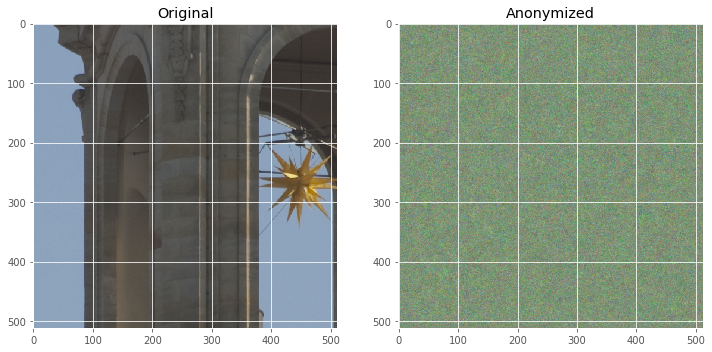

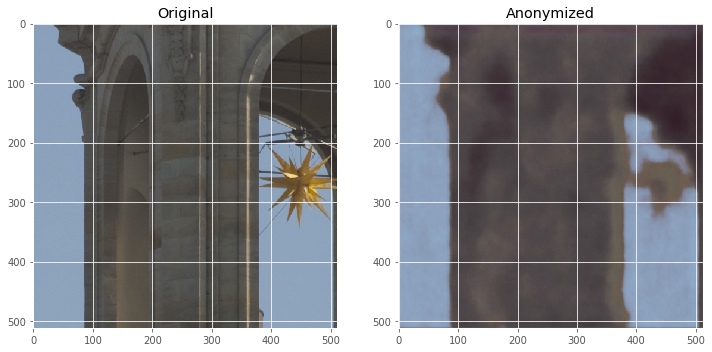

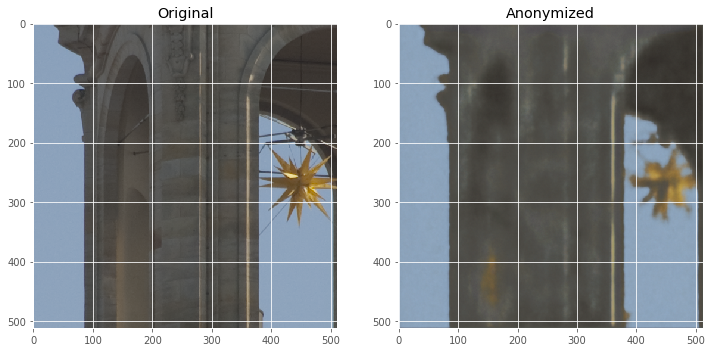

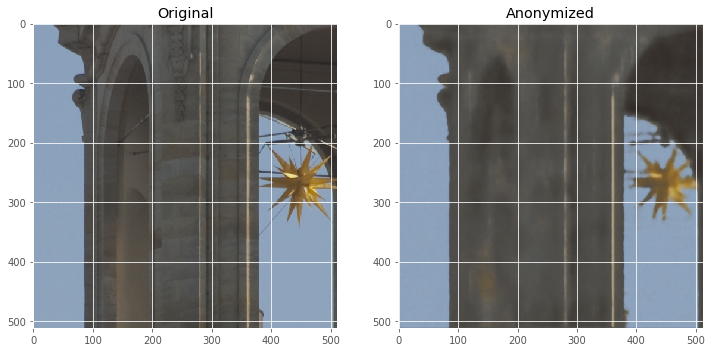

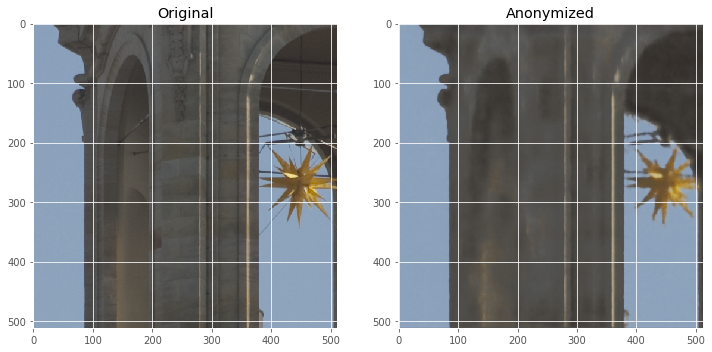

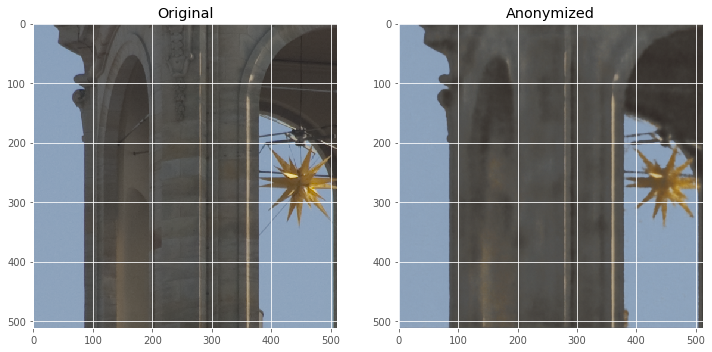

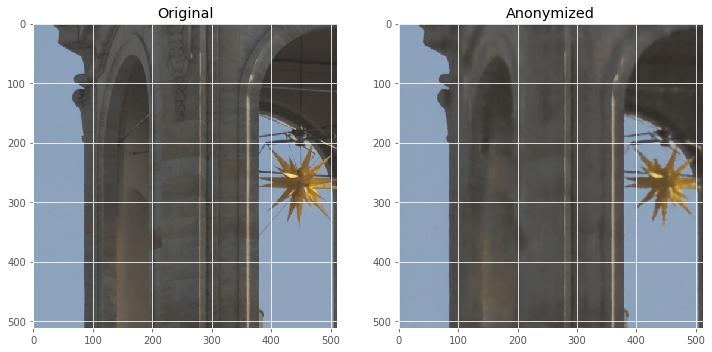

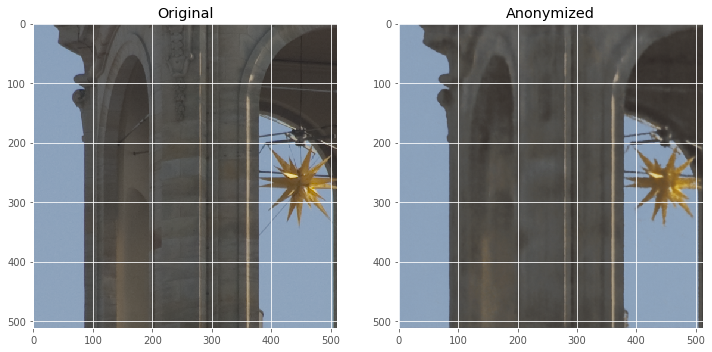

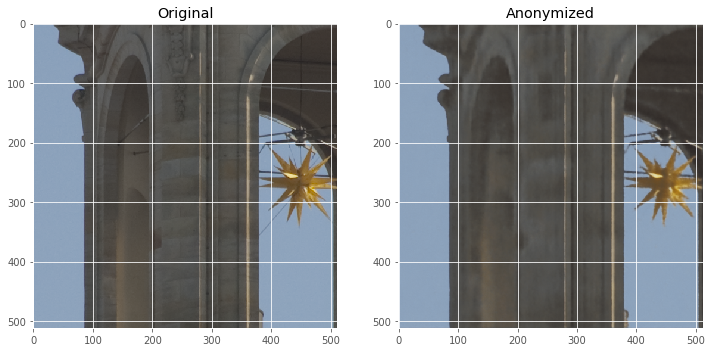

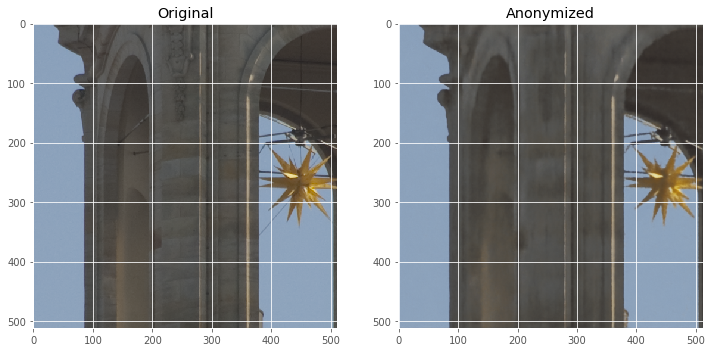

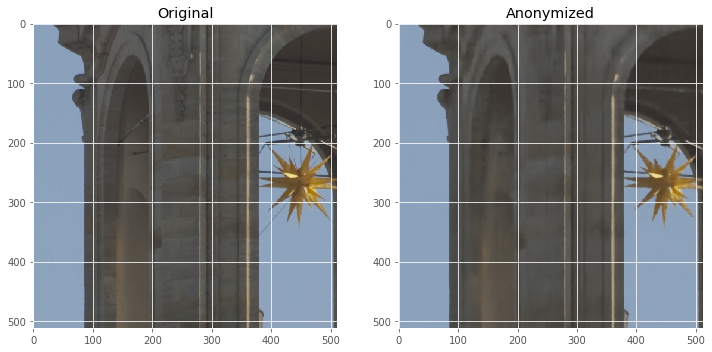

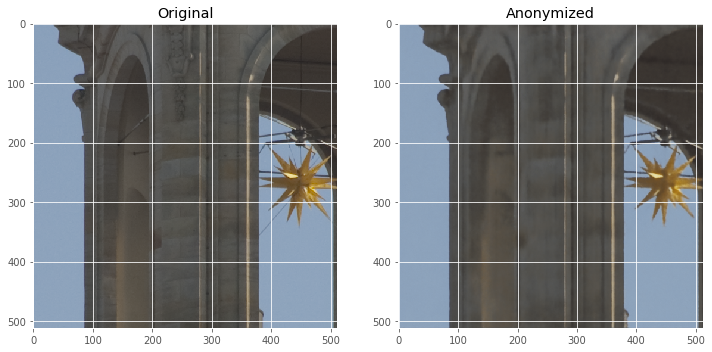

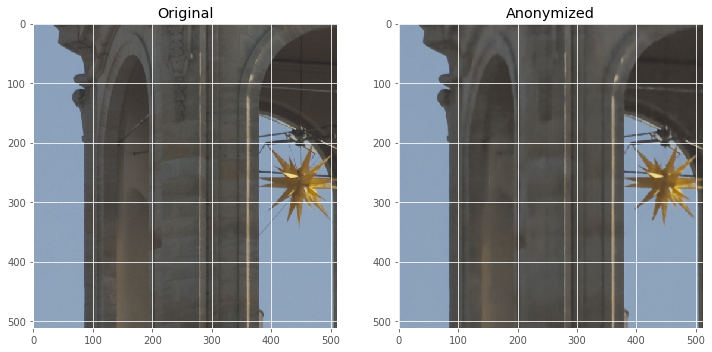

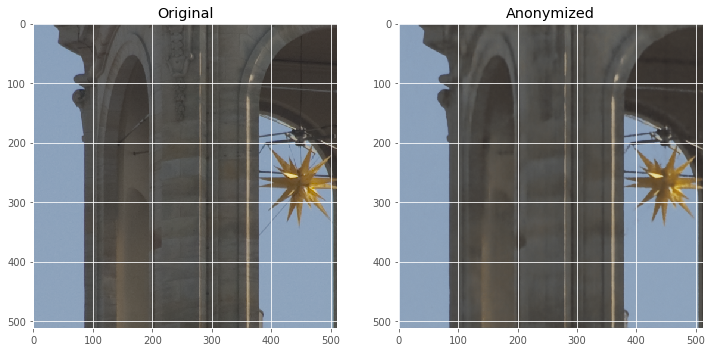

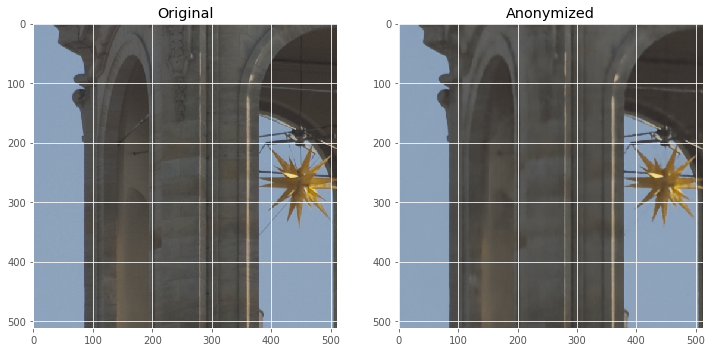

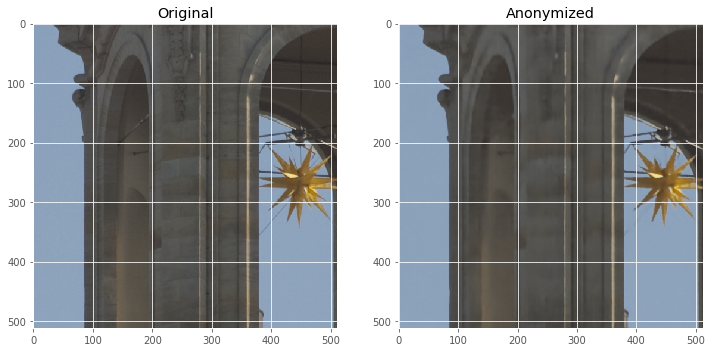

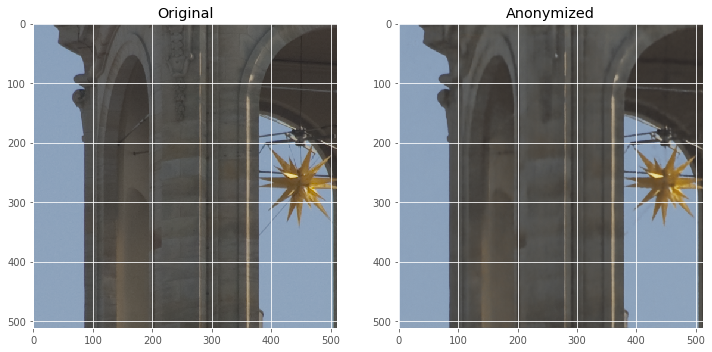

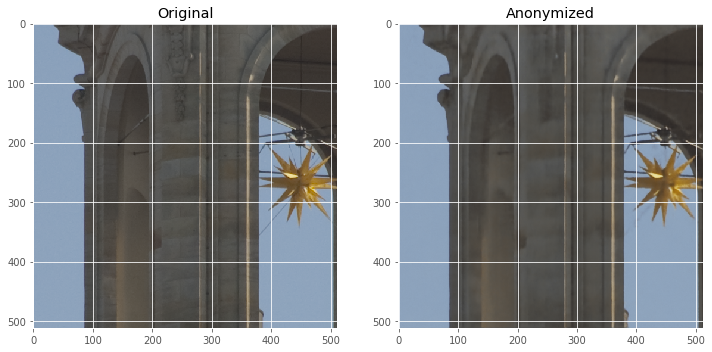

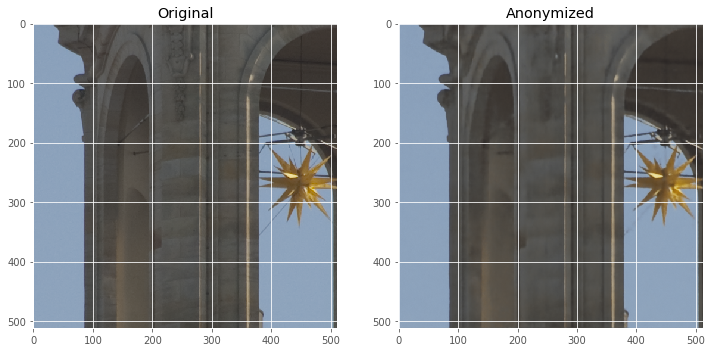

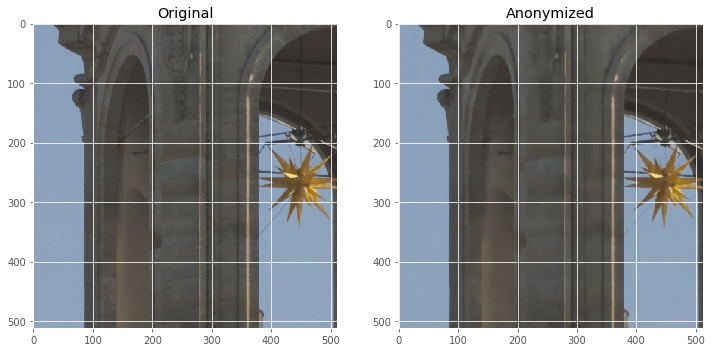

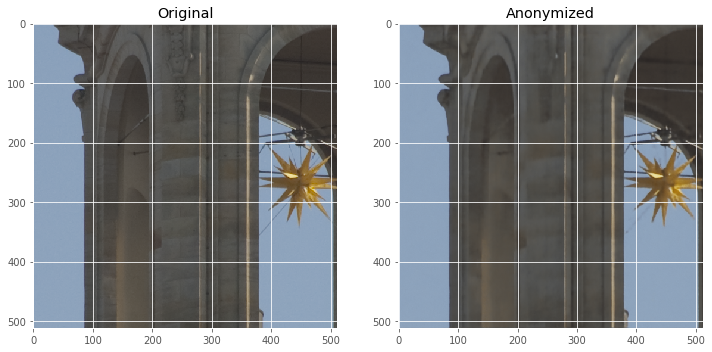

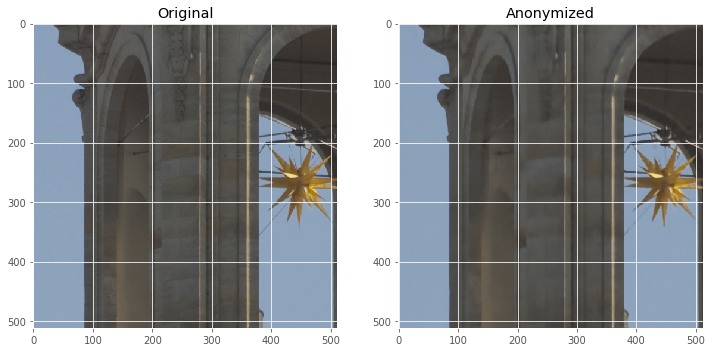

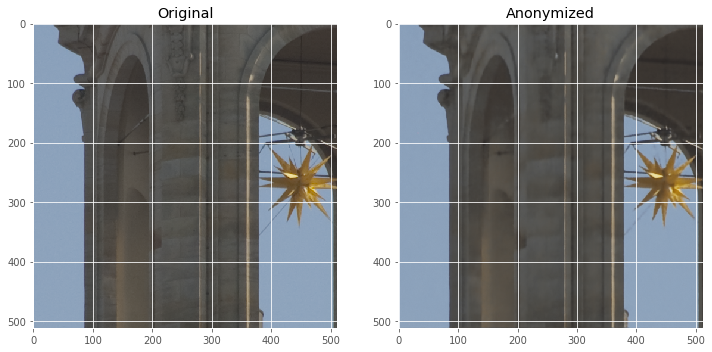

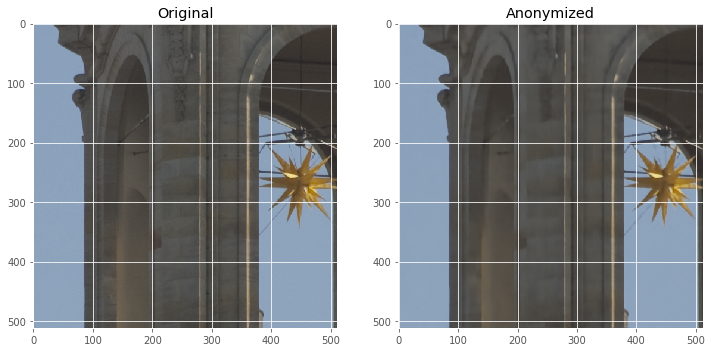

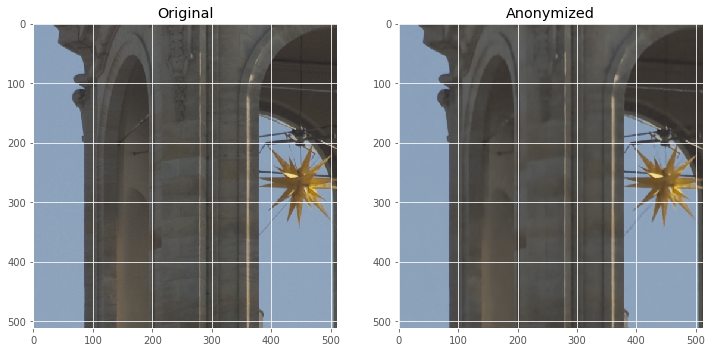

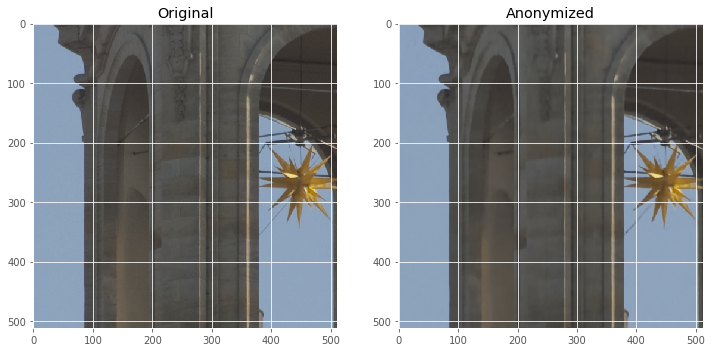

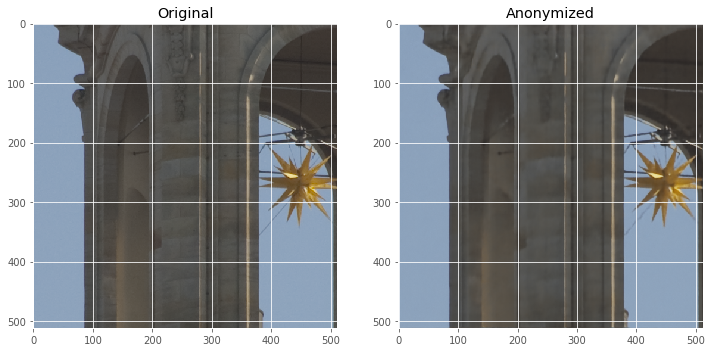

KeyboardInterrupt: 

In [11]:
# Training loop
p = get_params('net', net, input_tensor)
start = time()
optimize('adam', p, closure_function, lr, epochs)
elapsed = time() - start

In [ ]:
print('NCC from the original image = %.6f' % u.ncc(prnu, u.prnu.rgb2gray(img) * u.prnu.extract_single(u.float2png(img))))

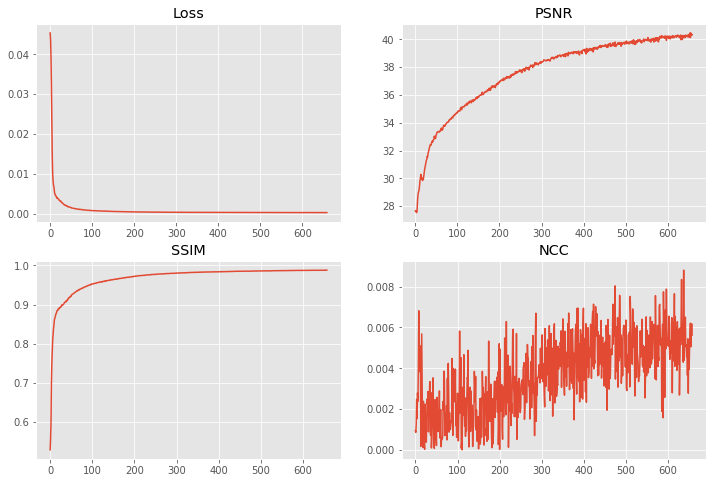

In [12]:
plt.figure(figsize=(12,8))
plt.subplot(221), plt.plot(history.loss), plt.title('Loss')
plt.subplot(222), plt.plot(history.psnr), plt.title('PSNR')
plt.subplot(223), plt.plot(history.ssim), plt.title('SSIM')
plt.subplot(224), plt.plot(history.ncc), plt.title('NCC')
plt.show()

In [14]:
cross = img_tensor @ prnu_tensor